---
title: "Tutorial - Suggesting mechanisms with networks"
author: "Shackett"
date: "May 9th 2025"
---

One of the primary goals of CPR is providing network-based answers to biological questions such as:
- how are species *X* and *Y* connected?
- what are the regulators of *X* and what are its downstream targets?
- what are common patterns shared among a set of species: {*X*, *Y*, *Z*, ...}?

In [17]:
#| label: config
import logging

import tutorial_utils

logger = logging.getLogger()
logger.setLevel("INFO")

config = tutorial_utils.NapistuConfig("config.yaml", "suggesting_mechanisms_with_networks")
sbml_dfs_path = config.load_asset("test_pathway", "sbml_dfs")
sbml_dfs_path = config.load_asset("test_pathway", "regulatory_graph")

In [18]:
#| label: env
import pandas as pd

from napistu import sbml_dfs_core
from napistu import mechanism_matching
from napistu import utils

from napistu.network import net_create
from napistu.network import paths
from napistu.network import neighborhoods
from napistu.network import ng_utils
from napistu.network import ig_utils

sbml_dfs = utils.load_pickle(config.artifacts["sbml_dfs"])
napistu_graph = utils.load_pickle(config.artifacts["napistu_graph"])

For this tutorial we will work with the "test pathway" which is bundled with Napistu. This is small metabolic model covering human central carbon metabolism. 

## Overview of `napistu_graph`

Before we start exploring the metabolic model as a graph, we can first visualize its overall structure. 

Doing this we'll create a version of the network using the `surrogate` layout. The key feature of this layout is that it places enzymes downstream of their substrates. This doesn't make sense from a regulatory perspective (the substrate is modified by the enzyme not the other way around), but it does make sense for descriptive visualization of networks. 

INFO:napistu.network.net_create:Organizing all network nodes (compartmentalized species and reactions)
INFO:napistu.network.net_create:Formatting edges as a surrogate graph
INFO:napistu.network.net_create:Formatting 339 reactions species as tiered edges.
INFO:napistu.network.net_create:Adding additional attributes to edges, e.g., # of children and parents.
INFO:napistu.network.net_create:Done preparing surrogate graph
INFO:napistu.network.net_create:Adding reversibility and other meta-data from reactions_data
INFO:napistu.network.net_create:No reactions annotations provided in "graph_attrs"; returning None
INFO:napistu.network.net_create:Creating reverse reactions for reversible reactions on a directed graph
INFO:napistu.network.net_create:Formatting cpr_graph output


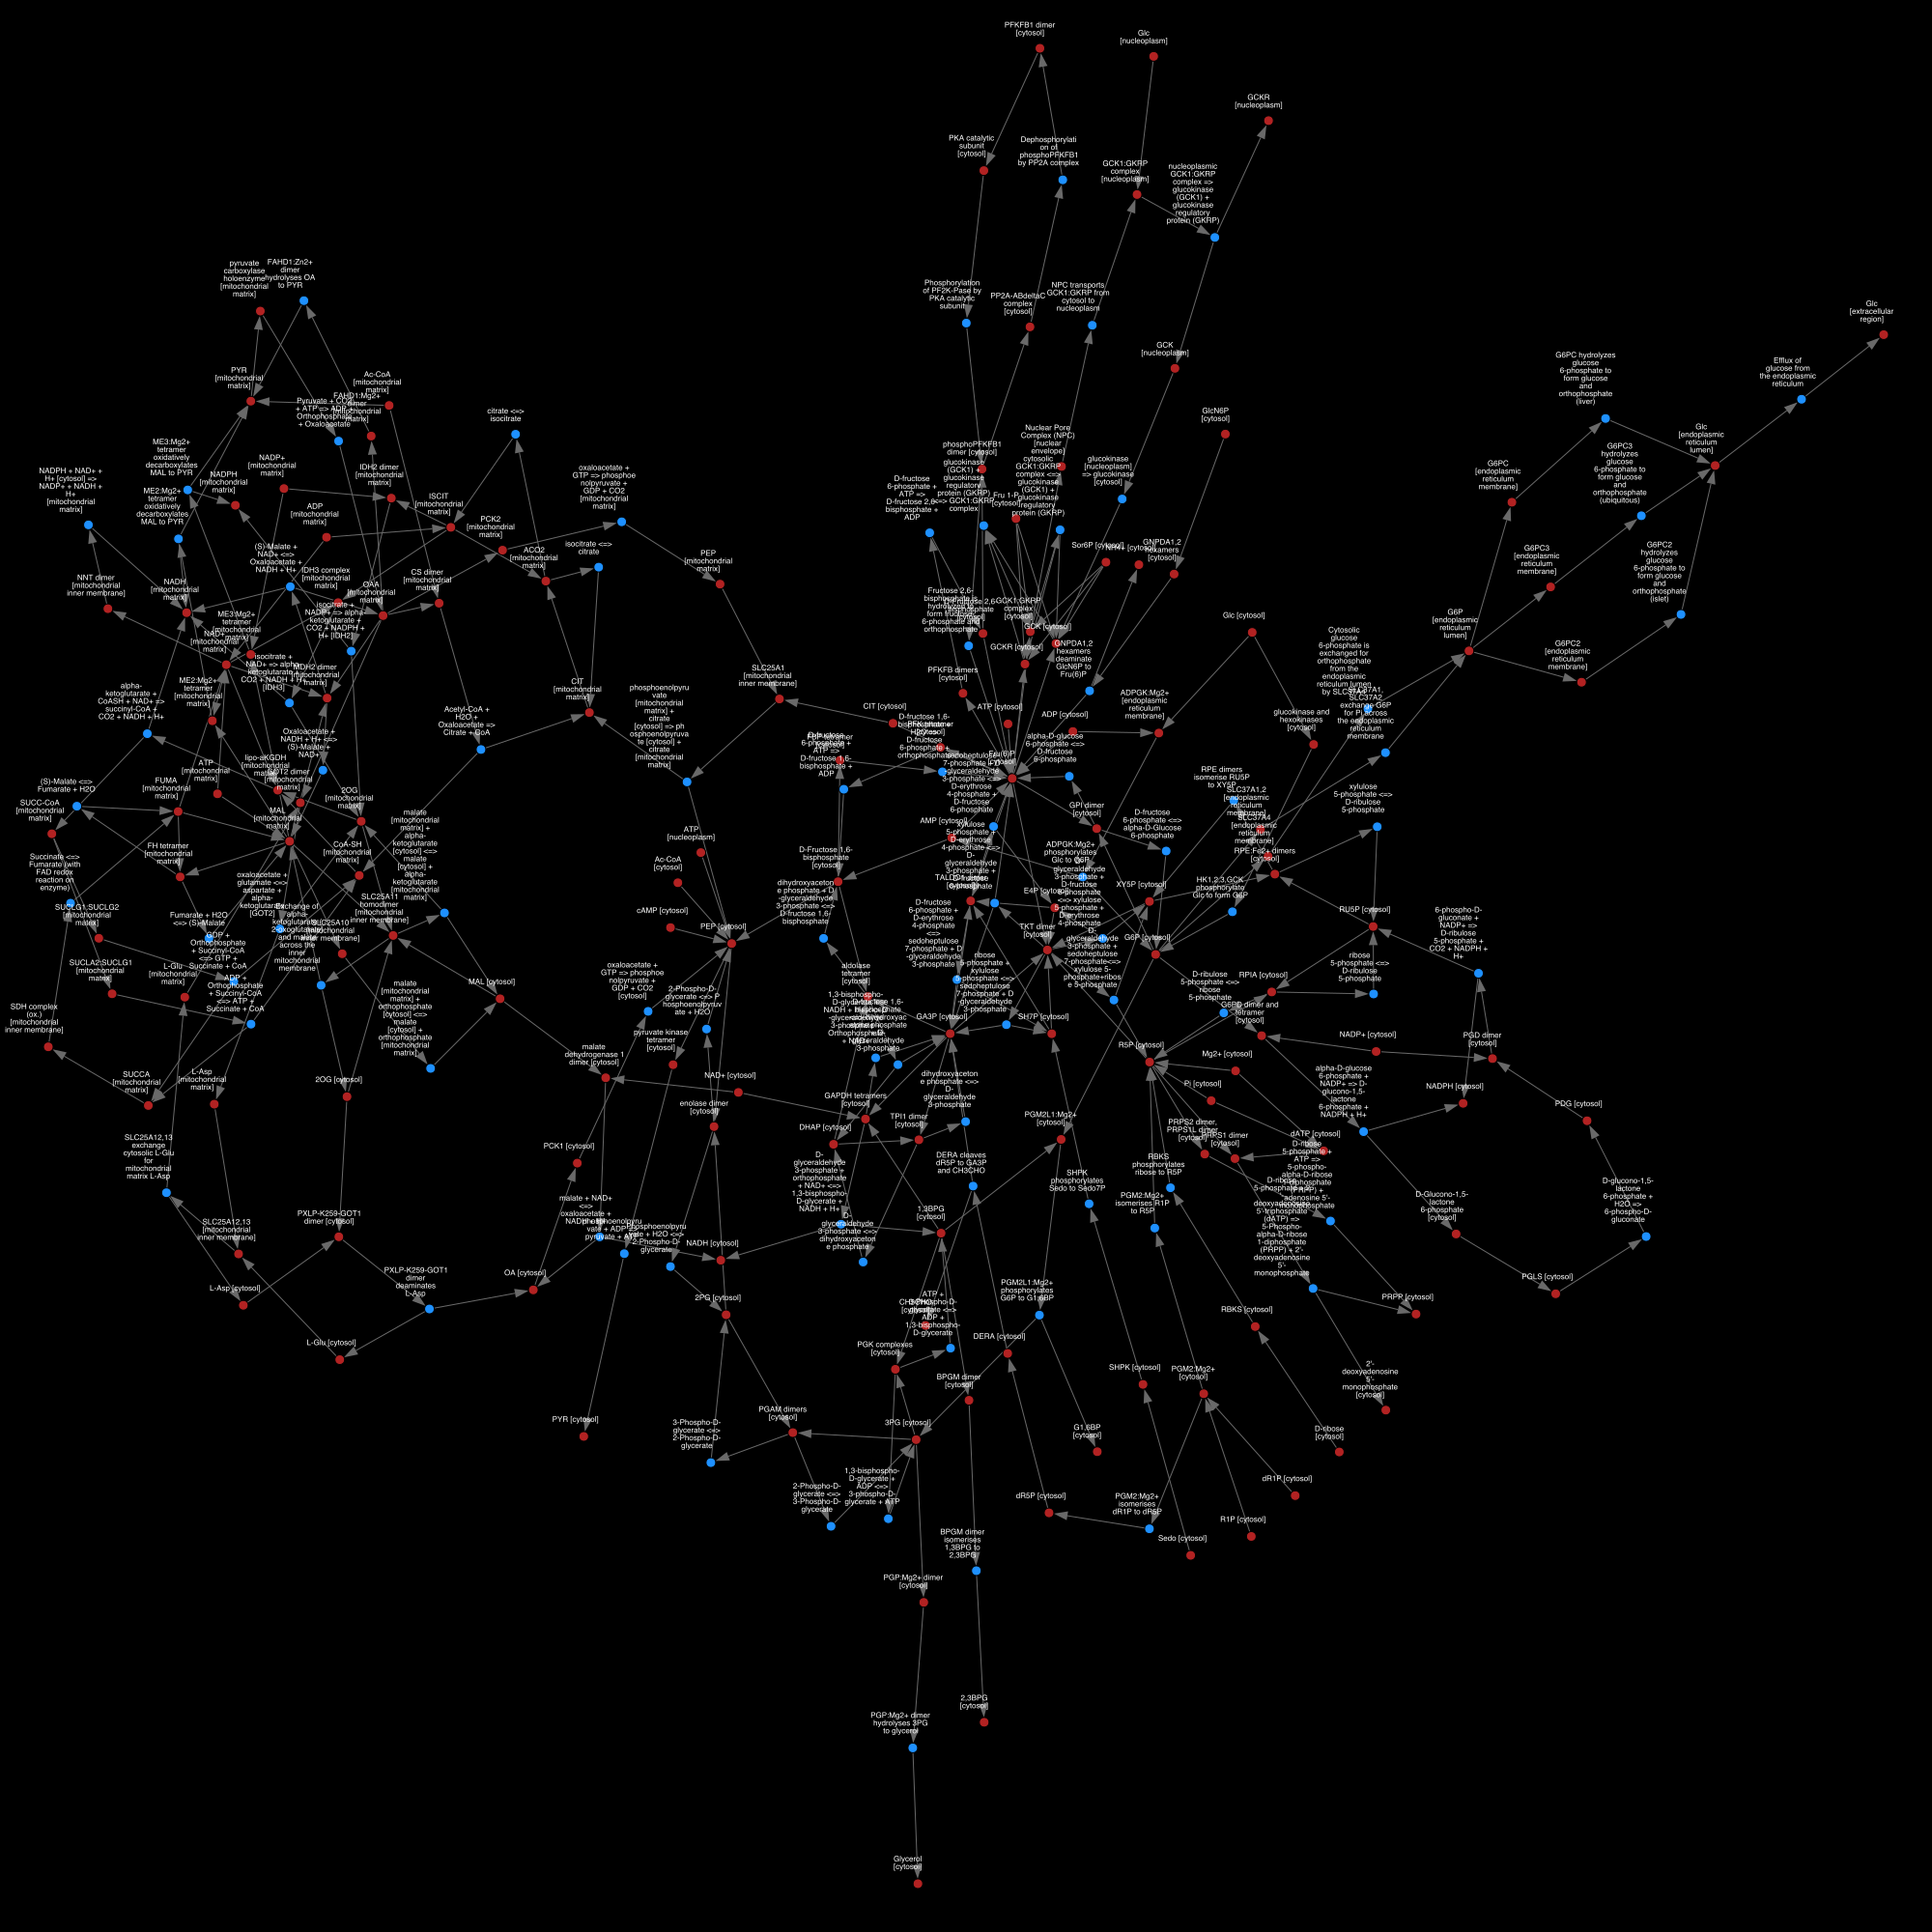

In [19]:
#| label: create_and_visualize_surrogate_graph
# create the surrogate graph
napistu_graph_surrogate = net_create.create_napistu_graph(sbml_dfs, wiring_approach = "surrogate")

# network visualization
neighborhoods.plot_neighborhood(
    ig_utils.filter_to_largest_subgraph(napistu_graph_surrogate),
    name_nodes = True,
    plot_size = 2000,
    network_layout = "kk" 
)

The networks used in cpr are just `igraph` `Graph` object with some additional vertex and edge attributes which are cpr-specific. This allows us to create, manipulate and visualize networks with igraph's extensive library, while also utilize the growing suite of network-based analysis approaches in CPR.

## Shortest paths

### Define source and destination species

As an example we can try and find a pathway between glucose and pyruvate on the graph. 

In [20]:
#| label: select_origin_and_dest_species
S_NAME_ORIGIN = "Glc"
S_NAME_DEST = "PYR"

all_species = sbml_dfs.species["s_name"].tolist()
all_species.sort()
all_species_str = ', '.join([f"'{x}'" for x in all_species])
print(all_species_str)

'1,3BPG', '2'-deoxyadenosine 5'-monophosphate', '2,3BPG', '2OG', '2PG', '3PG', 'ACO2', 'ADP', 'ADPGK:Mg2+', 'AMP', 'ATP', 'Ac-CoA', 'BPGM dimer', 'CH3CHO', 'CIT', 'CO2', 'CS dimer', 'CoA-SH', 'D-Fructose 1,6-bisphosphate', 'D-Fructose 2,6-bisphosphate', 'D-Glucono-1,5-lactone 6-phosphate', 'D-ribose', 'DERA', 'DHAP', 'E4P', 'FAHD1:Mg2+ dimer', 'FBP tetramer', 'FH tetramer', 'FUMA', 'Fru 1-P', 'Fru(6)P', 'G1,6BP', 'G6P', 'G6PC', 'G6PC2', 'G6PC3', 'G6PD dimer and tetramer', 'GA3P', 'GAPDH tetramers', 'GCK', 'GCK1:GKRP complex', 'GCK1:GKRP complex', 'GCKR', 'GDP', 'GNPDA1,2 hexamers', 'GOT2 dimer', 'GPI dimer', 'GTP', 'Glc', 'GlcN6P', 'Glycerol', 'H+', 'H2O', 'IDH2 dimer', 'IDH3 complex', 'ISCIT', 'L-Asp', 'L-Glu', 'MAL', 'MDH2 dimer', 'ME2:Mg2+ tetramer', 'ME3:Mg2+ tetramer', 'Mg2+', 'NAD+', 'NADH', 'NADP+', 'NADPH', 'NH4+', 'NNT dimer', 'Nuclear Pore Complex (NPC)', 'OAA', 'PCK1', 'PCK2', 'PDG', 'PEP', 'PFK tetramer', 'PFKFB dimers', 'PFKFB1 dimer', 'PGAM dimers', 'PGD dimer', 'PGK comp

In [21]:
#| label: inspect_source_and_dest
species = sbml_dfs.species

source_species = species[species["s_name"] == S_NAME_ORIGIN]
for spec in source_species.index:
    print("\n" + spec + "\n")
    display(sbml_dfs_core.species_status(spec, sbml_dfs))

dest_species = species[species["s_name"] == S_NAME_DEST]
for spec in dest_species.index:
    print("\n" + spec + "\n")
    display(sbml_dfs_core.species_status(spec, sbml_dfs))


S00000075



,sc_name,stoichiometry,r_name,r_formula_str
0,Glc [cytosol],-1.0,"HK1,2,3,GCK phosphorylate Glc to form G6P",Glc -> G6P ---- modifiers: glucokinase and hex...
1,Glc [cytosol],-1.0,ADPGK:Mg2+ phosphorylates Glc to G6P,ADP [cytosol] + Glc [cytosol] -> AMP [cytosol]...
2,Glc [endoplasmic reticulum lumen],1.0,G6PC2 hydrolyzes glucose 6-phosphate to form g...,G6P [endoplasmic reticulum lumen] -> Glc [endo...
3,Glc [endoplasmic reticulum lumen],1.0,G6PC hydrolyzes glucose 6-phosphate to form gl...,G6P [endoplasmic reticulum lumen] -> Glc [endo...
4,Glc [endoplasmic reticulum lumen],1.0,G6PC3 hydrolyzes glucose 6-phosphate to form g...,G6P [endoplasmic reticulum lumen] -> Glc [endo...
5,Glc [endoplasmic reticulum lumen],-1.0,Efflux of glucose from the endoplasmic reticulum,Glc [endoplasmic reticulum lumen] -> Glc [extr...
6,Glc [extracellular region],1.0,Efflux of glucose from the endoplasmic reticulum,Glc [endoplasmic reticulum lumen] -> Glc [extr...
7,Glc [nucleoplasm],0.0,nucleoplasmic GCK1:GKRP complex => glucokinase...,GCK1:GKRP complex -> GCK + GCKR ---- modifiers...



S00000008



,sc_name,stoichiometry,r_name,r_formula_str
0,PYR [mitochondrial matrix],1.0,ME2:Mg2+ tetramer oxidatively decarboxylates M...,NAD+ + MAL -> NADH + PYR ---- modifiers: ME2:M...
1,PYR [mitochondrial matrix],1.0,ME3:Mg2+ tetramer oxidatively decarboxylates M...,MAL + NADP+ -> PYR + NADPH ---- modifiers: ME3...
2,PYR [mitochondrial matrix],1.0,FAHD1:Zn2+ dimer hydrolyses OA to PYR,OAA -> PYR ---- modifiers: FAHD1:Mg2+ dimer] [...
3,PYR [mitochondrial matrix],-1.0,Pyruvate + CO2 + ATP => ADP + Orthophosphate +...,PYR -> OAA ---- modifiers: Ac-CoA + pyruvate c...
4,PYR [cytosol],1.0,phosphoenolpyruvate + ADP => pyruvate + ATP,PEP [cytosol] -> PYR [cytosol] ---- modifiers:...


Since CPR reactions relate molecular species in a specific compartment (compartmentalized species), we need to find the cspecies which match the source and target species. In a compartmentalized model the source and destination species may exist in multiple compartments so we'll try to identify the path from each source cspecies to each destination cspecies.

In [22]:
#| label: compartmentalize_for_paths
target_species_paths = ng_utils.compartmentalize_species_pairs(
    sbml_dfs, source_species.index.tolist(), dest_species.index.tolist()
)
target_species_paths

,s_id_origin,s_id_dest,sc_id_origin,sc_id_dest
0,S00000075,S00000008,SC00000097,SC00000014
1,S00000075,S00000008,SC00000097,SC00000015
2,S00000075,S00000008,SC00000098,SC00000014
3,S00000075,S00000008,SC00000098,SC00000015
4,S00000075,S00000008,SC00000099,SC00000014
5,S00000075,S00000008,SC00000099,SC00000015
6,S00000075,S00000008,SC00000100,SC00000014
7,S00000075,S00000008,SC00000100,SC00000015


### Find all shortest weighted paths between the source and destination species

In [23]:
#| label: find_shortest_paths
(
    all_shortest_reaction_paths_df,
    all_shortest_reaction_path_edges_df,
    edge_sources,
    paths_graph,
) = paths.find_all_shortest_reaction_paths(
    napistu_graph, sbml_dfs, target_species_paths, weight_var="weights"
)

INFO:napistu.network.paths:precomputed_distances were not provided; all paths will be calculated on-the-fly


In [24]:
#| label: shortest_path
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):  # more options can be specified also
    display(all_shortest_reaction_path_edges_df.query("path == 0"))
    display(all_shortest_reaction_path_edges_df.query("path == 0"))

,index,from,to,path,weights,sbo_term,direction,link_polarity,net_polarity,origin,dest
0,0,SC00000097,R00000052,0,1,SBO:0000010,forward,activation,activation,SC00000097,SC00000015
1,1,R00000052,SC00000073,0,1,SBO:0000011,forward,activation,activation,SC00000097,SC00000015
2,2,SC00000073,SC00000157,0,1,SBO:0000020,forward,inhibition,inhibition,SC00000097,SC00000015
3,3,SC00000157,SC00000094,0,1,SBO:0000013,forward,activation,inhibition,SC00000097,SC00000015
4,4,SC00000094,SC00000127,0,1,SBO:0000459,forward,activation,inhibition,SC00000097,SC00000015
5,5,SC00000127,SC00000120,0,1,SBO:0000013,forward,activation,inhibition,SC00000097,SC00000015
6,6,SC00000120,R00000023,0,1,SBO:0000010,forward,activation,inhibition,SC00000097,SC00000015
7,7,R00000023,SC00000015,0,1,SBO:0000011,forward,activation,inhibition,SC00000097,SC00000015


,index,from,to,path,weights,sbo_term,direction,link_polarity,net_polarity,origin,dest
0,0,SC00000097,R00000052,0,1,SBO:0000010,forward,activation,activation,SC00000097,SC00000015
1,1,R00000052,SC00000073,0,1,SBO:0000011,forward,activation,activation,SC00000097,SC00000015
2,2,SC00000073,SC00000157,0,1,SBO:0000020,forward,inhibition,inhibition,SC00000097,SC00000015
3,3,SC00000157,SC00000094,0,1,SBO:0000013,forward,activation,inhibition,SC00000097,SC00000015
4,4,SC00000094,SC00000127,0,1,SBO:0000459,forward,activation,inhibition,SC00000097,SC00000015
5,5,SC00000127,SC00000120,0,1,SBO:0000013,forward,activation,inhibition,SC00000097,SC00000015
6,6,SC00000120,R00000023,0,1,SBO:0000010,forward,activation,inhibition,SC00000097,SC00000015
7,7,R00000023,SC00000015,0,1,SBO:0000011,forward,activation,inhibition,SC00000097,SC00000015


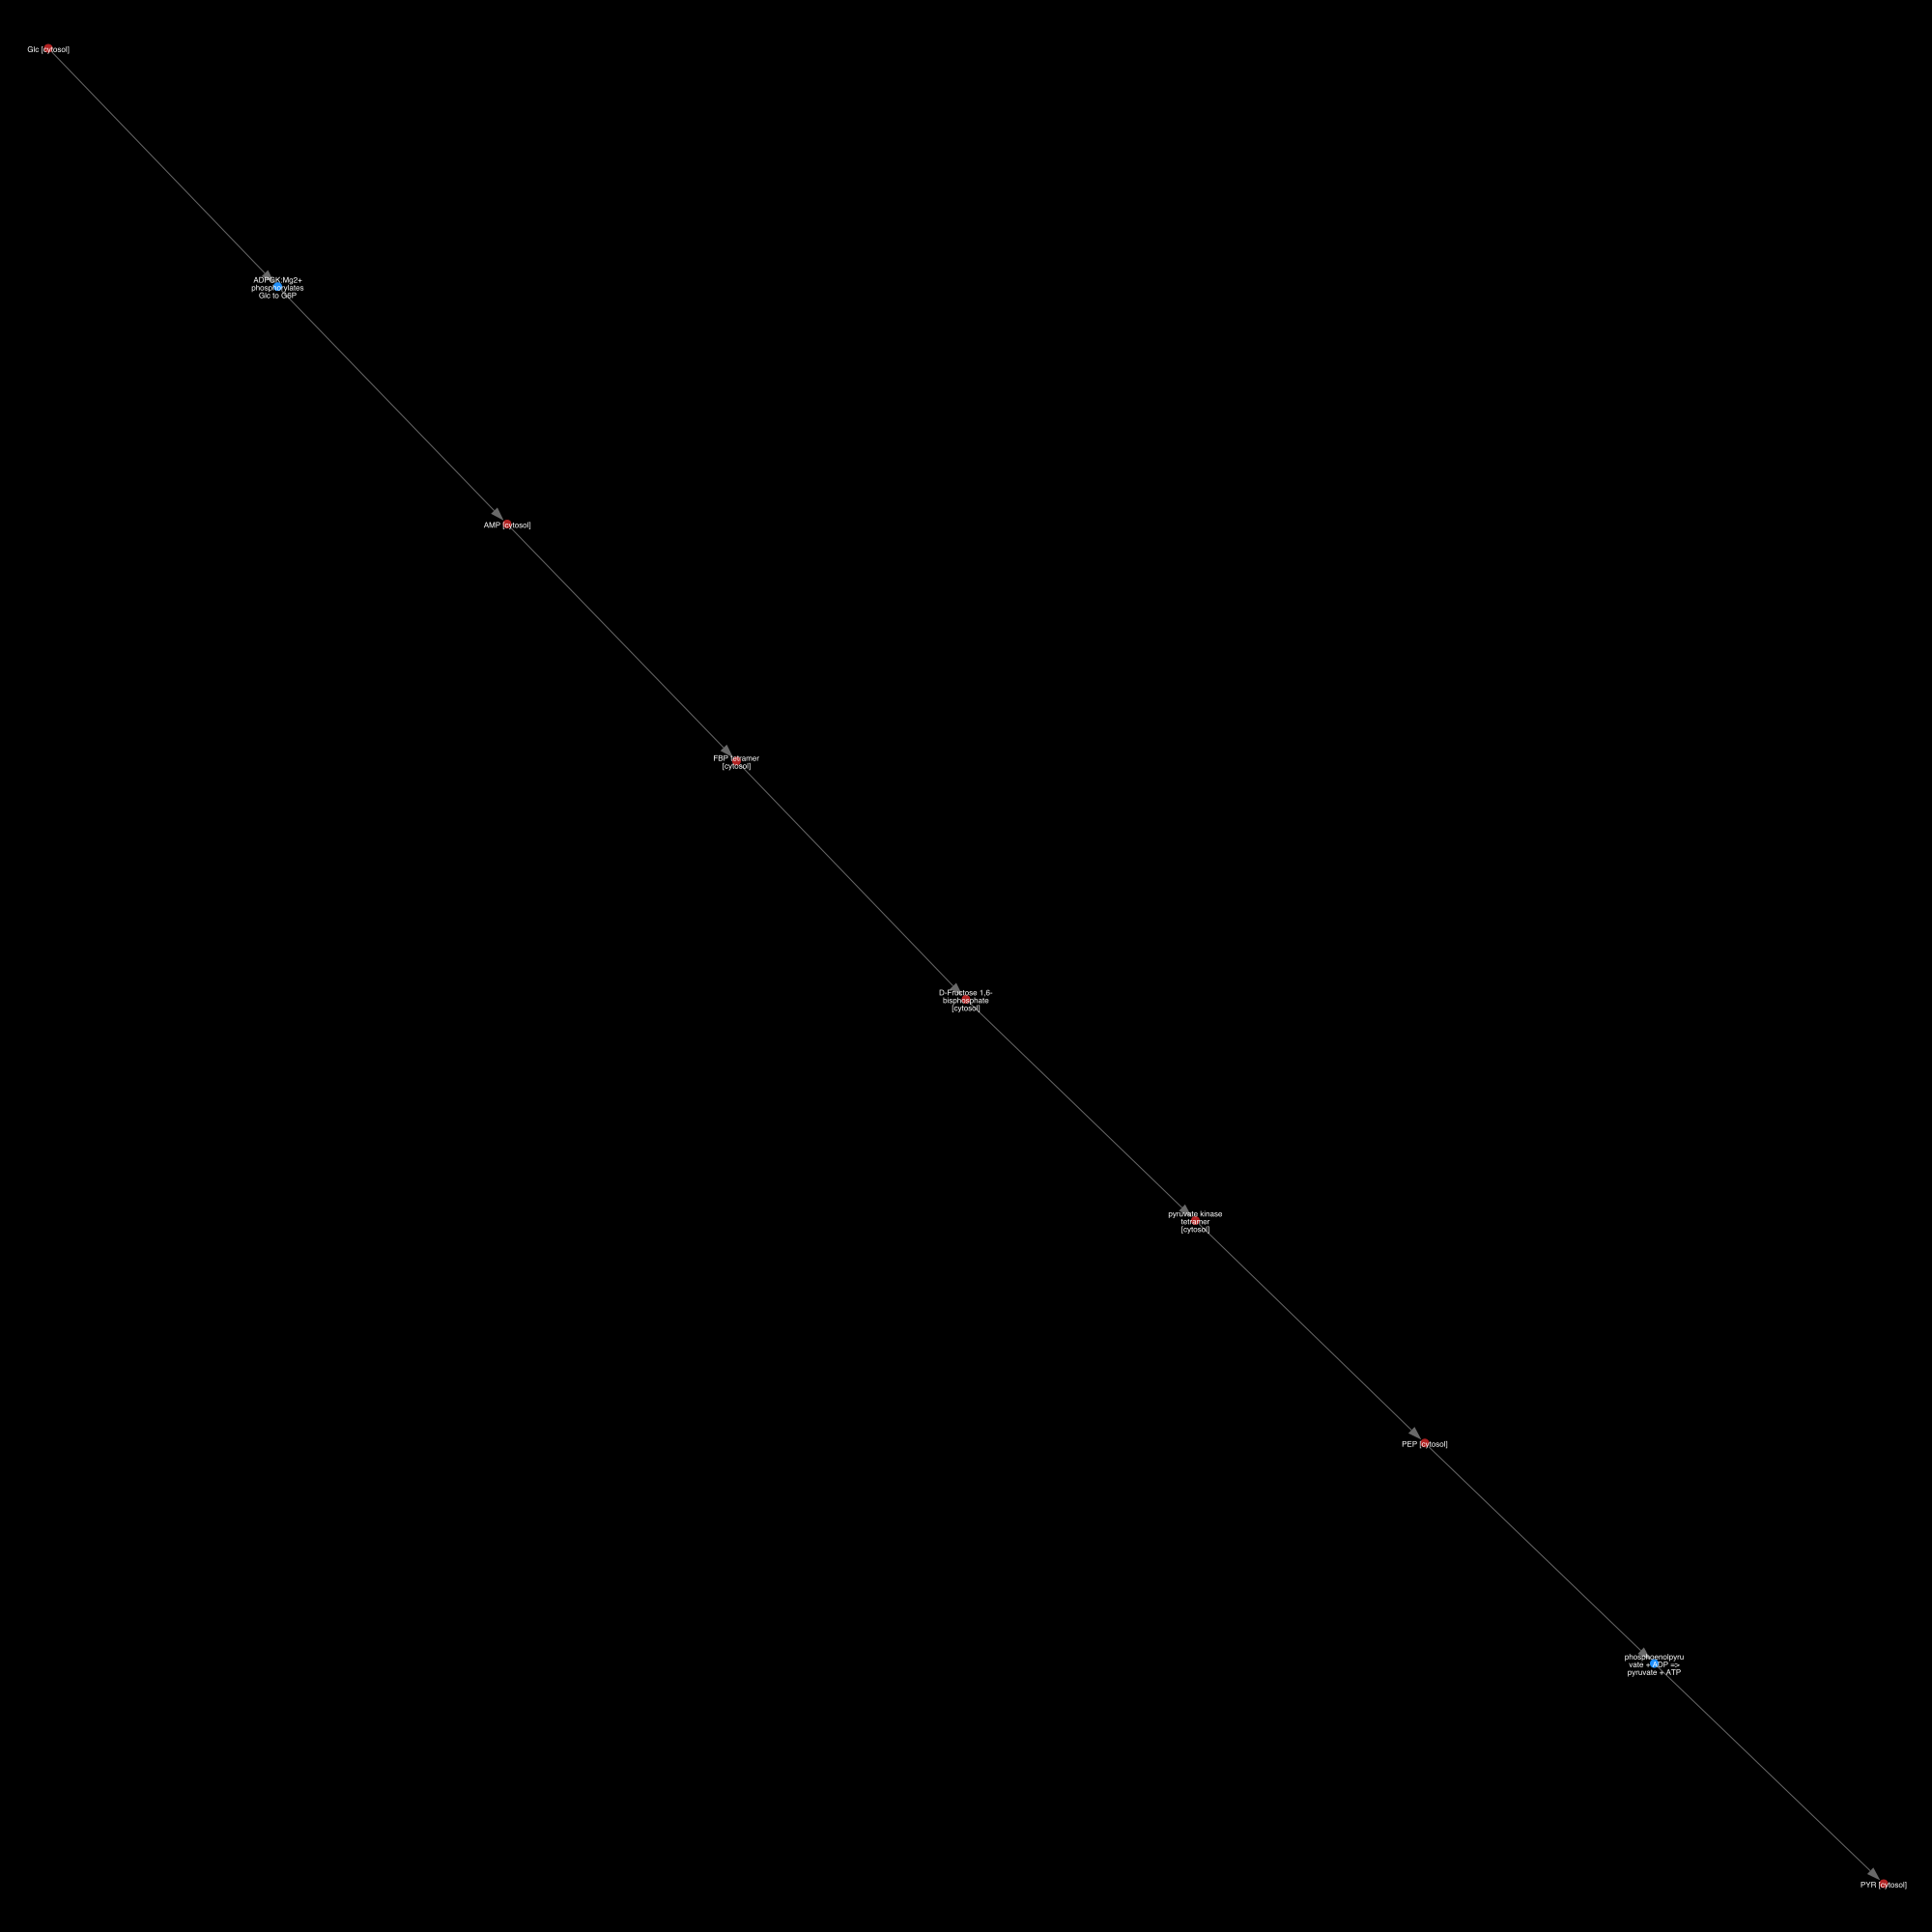

In [25]:
#| label: plot_shortest_paths
paths.plot_shortest_paths(paths_graph)

### Scaling Shortest Paths with Mechanism Matching

In [26]:
#| label: mock_edgelist
edgelist = pd.DataFrame([
    {"identifier_upstream" : "17925", "identifier_downstream" : "32966"}, # glu, fbp
    {"identifier_upstream" : "57634", "identifier_downstream" : "32966"}, # f6p, fbp
    {"identifier_upstream" : "32966", "identifier_downstream" : "57642"}, # fbp, dhap
    {"identifier_upstream" : "17925", "identifier_downstream" : "15361"}, # glu, pyr
])

species_identifiers = sbml_dfs.get_identifiers("species")

#### Direct interactions

Participants in the same reaction

In [27]:
#| label: direct_interactions
direct_interactions = mechanism_matching.filter_to_direct_mechanistic_interactions(
    formatted_edgelist=edgelist,
    sbml_dfs=sbml_dfs,
    species_identifiers=species_identifiers,
    ontologies = {"chebi"}
)

utils.style_df(direct_interactions)

INFO:napistu.mechanism_matching:14 interactions mapped onto pairs of compartmentalized species in the mechanistic model


,identifier_upstream,identifier_downstream,s_id_upstream,s_id_downstream,sc_id_upstream,sc_id_downstream,r_id,s_name_upstream,s_name_downstream,r_name
0,57634,32966,S00000050,S00000072,SC00000071,SC00000094,R00000030,Fru(6)P,"D-Fructose 1,6-bisphosphate","D-fructose 6-phosphate + ATP => D-fructose 1,6-bisphosphate + ADP"
1,32966,57642,S00000072,S00000088,SC00000094,SC00000115,R00000066,"D-Fructose 1,6-bisphosphate",DHAP,"D-fructose 1,6-bisphosphate <=> dihydroxyacetone phosphate + D-glyceraldehyde 3-phosphate"


#### Indirect interactions

Finding paths between all pairs of vertices

In [28]:
#| label: indirect_interactions
indirect_interactions = mechanism_matching.filter_to_indirect_mechanistic_interactions(
    formatted_edgelist=edgelist,
    sbml_dfs=sbml_dfs,
    species_identifiers=species_identifiers,
    napistu_graph=napistu_graph,
    ontologies = {"chebi"},
    precomputed_distances=None,
    max_path_length=10,
)

utils.style_df(indirect_interactions.assign(vpath = "###").assign(epath = "###"))

INFO:napistu.mechanism_matching:14 interactions mapped onto pairs of compartmentalized species in the mechanistic model


,identifier_upstream,identifier_downstream,s_id_upstream,s_id_downstream,sc_id_upstream,sc_id_downstream,from,to,weight,path_length,vpath,epath
0,17925,32966,S00000075,S00000072,SC00000097,SC00000094,SC00000097,SC00000094,4,4,###,###
1,57634,32966,S00000050,S00000072,SC00000071,SC00000094,SC00000071,SC00000094,2,2,###,###
2,17925,15361,S00000075,S00000008,SC00000097,SC00000015,SC00000097,SC00000015,8,8,###,###
3,32966,57642,S00000072,S00000088,SC00000094,SC00000115,SC00000094,SC00000115,2,2,###,###


## Find neighbors within N steps of a species

INFO:napistu.network.neighborhoods:SC00000097 neighborhood: ancestors: 3 species; descendants: 24 reactions and 28 species
INFO:napistu.network.neighborhoods:SC00000098 neighborhood: ancestors: 1 species; descendants: 3 reactions and 5 species
INFO:napistu.network.neighborhoods:SC00000099 neighborhood: ancestors: 8 reactions and 14 species; descendants: 1 reactions and 2 species
INFO:napistu.network.neighborhoods:SC00000100 neighborhood: ancestors: 6 reactions and 7 species; descendants: 1 species


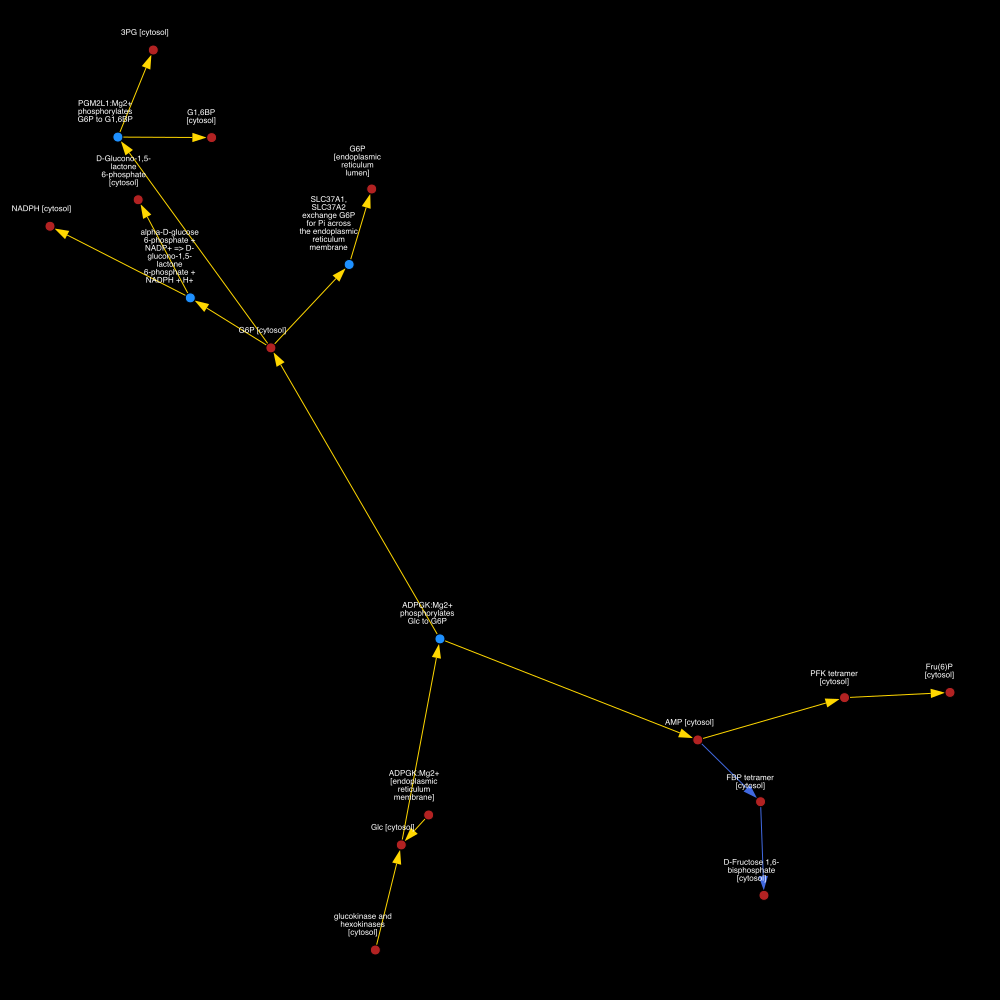

In [29]:
#| label: create_hourglass
# select the focal species to center the neighborhood on (like in the previous examples we'll use glucose

focal_species = species[species["s_name"] == S_NAME_ORIGIN].index.tolist()

focal_sc_species = ng_utils.compartmentalize_species(sbml_dfs, focal_species)["sc_id"].tolist()

neighbors = neighborhoods.find_neighborhoods(
    sbml_dfs,
    napistu_graph,
    compartmentalized_species=focal_sc_species,
    network_type="hourglass",
    order=6,
)

pruned_neighborhoods = neighborhoods.prune_neighborhoods(neighbors, top_n=10)

neighborhoods.plot_neighborhood(
    pruned_neighborhoods[focal_sc_species[0]]["graph"], True
)

In [1]:
from napistu.network import ng_utils

/Users/sean/Desktop/GITHUB/napistu/dev/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [3]:
from importlib.metadata import version
version("napistu")

'0.3.3'